In [1]:
import anndata as ad
import scanpy as sc
import scvi
import os
import pandas as pd
import numpy as np
#set seeds for reproducibility
scvi.settings.seed = 100

In [2]:
import warnings
warnings.filterwarnings('ignore')
#this will hide the awful pandas deprec warnings that are currently plaguing scanpy

#now print versions
print(sc.__version__)
print(ad.__version__)
print(scvi.__version__)
print(pd.__version__)

1.7.1
0.7.5
0.9.1
1.0.4


In [3]:
#peak into our directory to find the data..
os.listdir('../data')

['HLN_linear_models_latent_rep.csv',
 'bc_hln_raw.h5ad',
 'HLN_linear_models_loadings.csv',
 'TIC_atlas',
 'preprocessed_adata.h5ad',
 'B_cell_atlas',
 'celltypist_in.h5ad',
 'sanger_hln_raw.h5ad',
 'scvi_trained_adata.h5ad',
 'sanger_LN_meta.csv',
 'sanger_ln_raw.h5ad',
 'celltype_markers.RDS',
 'merged_sc_obj_CancerDiscovery.Rdata',
 '.ipynb_checkpoints']

In [4]:
adata = sc.read_h5ad('../data/preprocessed_adata.h5ad') #read in our data
pd.crosstab(adata.obs.disease, adata.obs.centre)

centre,WSI,bc_cancer
disease,,
HDLR,0,4764
HDMC,0,38668
HDNLP,21968,0
HDNS,16912,60857
healthy,83222,0
reactive_lymph_node,0,23374


In [5]:
pd.crosstab(adata.obs.centre, adata.obs.tenx_run)

tenx_run,284C,290B,292B,295B,298C,302C,337C,414C,CHIP1,CHIP2,CHIP3,CHIP4,CHIP5,CHIP6,CHIP7,CHIP9,WSI_HLN_donor_1,WSI_HLN_donor_2
centre,,,,,,,,,,,,,,,,,,
WSI,45052,9494,962,6584,5763,2005,12525,837,0,0,0,0,0,0,0,0,16912,21968
bc_cancer,0,0,0,0,0,0,0,0,8931,11443,20759,16549,21855,19180,14503,14443,0,0


In [6]:
pd.crosstab(adata.obs.centre, adata.obs.cell_selection)

cell_selection,CD4+ T cells,CD45+_non_T_cells,unselected
centre,,,
WSI,5238,5714,111150
bc_cancer,0,0,127663


In [7]:
adata

AnnData object with n_obs × n_vars = 249765 × 32991
    obs: 'empty_drops', 'dd', 'channel', 'disease', 'anatomy', 'centre', 'donor', 'tenx_run', 'cell_selection', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'qc_cuts', 'scrublet_scores', 'scrublet_cuts'
    var: 'ID', 'Symbol', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'core_exclude'
    layers: 'counts'

In [8]:
#do some filtering of genes
sc.pp.filter_genes(adata, min_counts = 10)

In [9]:
#now get rid of the non important genes that cause problems with clusters
orig_adata = adata.copy()

In [10]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

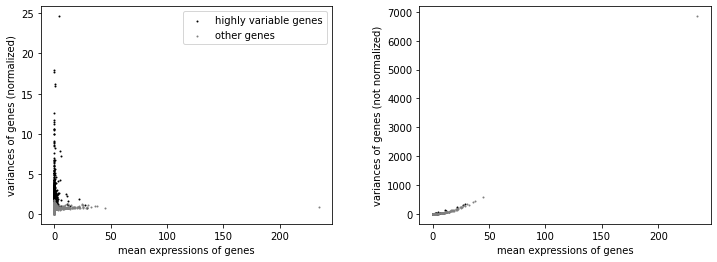

In [11]:
#call highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    subset=False,
    layer="counts",
    flavor="seurat_v3",
   batch_key="tenx_run"
)
sc.pl.highly_variable_genes(adata)

In [12]:
sc.pp.pca(adata) #this is useful to stash for later.. 
adata.raw = adata.copy() #freeze state in raw
#call highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="donor"
)


In [13]:
#get rid of nuissance genes regex
#var_bool = np.logical_and(adata.var.highly_variable, adata.var.core_exclude)
#adata.var.highly_variable = var_bool

In [14]:
adata

AnnData object with n_obs × n_vars = 249765 × 3000
    obs: 'empty_drops', 'dd', 'channel', 'disease', 'anatomy', 'centre', 'donor', 'tenx_run', 'cell_selection', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'qc_cuts', 'scrublet_scores', 'scrublet_cuts'
    var: 'ID', 'Symbol', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'core_exclude', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

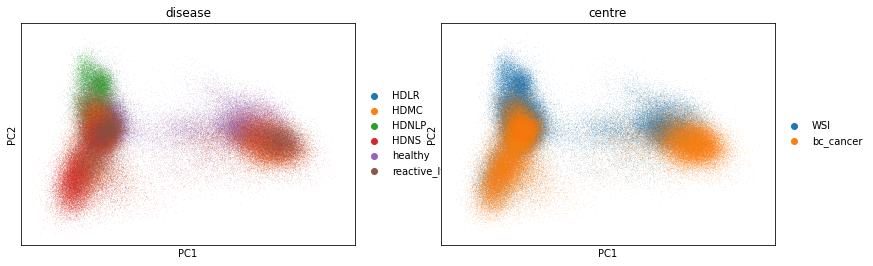

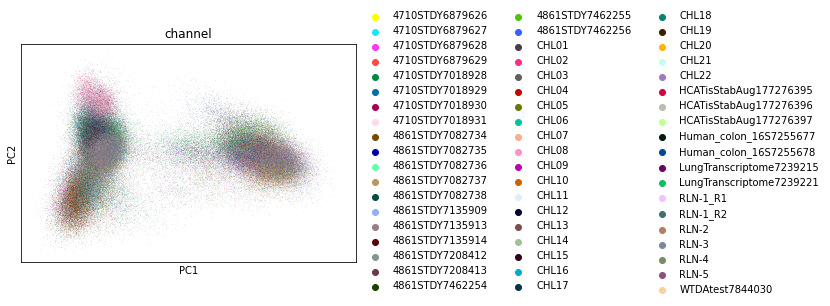

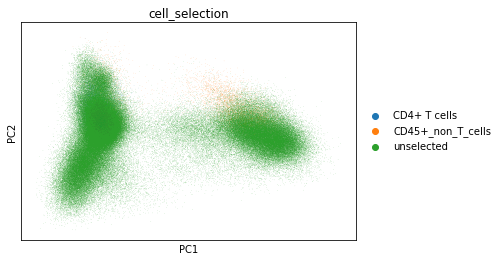

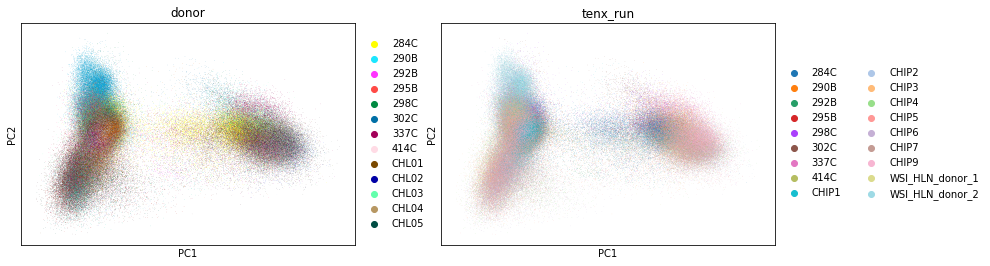

In [15]:
sc.pl.pca(adata, color = ['disease', 'centre'])
sc.pl.pca(adata, color = ['channel'])
sc.pl.pca(adata, color = ['cell_selection'])
sc.pl.pca(adata, color = ['donor', 'tenx_run'])

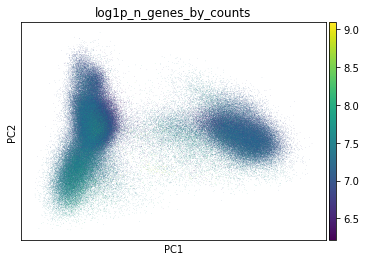

In [16]:
sc.pl.pca(adata, color =['log1p_n_genes_by_counts'], components = ["1,2"])

In [17]:
#now we set up the scvi model
scvi.data.setup_anndata(adata, layer = 'counts', 
                       #continuous_covariate_keys = ['n_genes_by_counts'],
                        batch_key = 'donor'
                       )

INFO     Using batches from adata.obs["donor"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 249765 cells, 3000 vars, 37       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [18]:
#set up the model using SCVI
scvi_model = scvi.model.SCVI(adata, n_latent = 15, n_layers=2)
scvi_model

In [19]:
scvi.data.view_anndata_setup(scvi_model.adata)

In [20]:
#train the SCVI model
scvi_model.train()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 32/32: 100%|██████████| 32/32 [08:16<00:00, 15.50s/it, loss=401, v_num=1]


In [21]:
scvi_model

In [22]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation()

In [23]:
adata = adata.raw.to_adata()

In [24]:
#add the counts back to the object.
adata.layers['counts'] = orig_adata.layers['counts'] #add back the counts

In [25]:
#try out pymde
#import pymde
#pm_out = pymde.preserve_neighbors(adata.obsm['X_scVI'])
#pm_embedding = pm_out.embed()
#pm_embedding = pm_embedding.numpy()
#pm_embedding = pd.DataFrame(pm_embedding, index= adata.obs_names)
#adata.obsm['X_mde'] = pm_embedding
#sc.pl.embedding(adata, basis = "X_mde", color = ['tenx_run', 'centre', 'disease']) #plot the embedding out

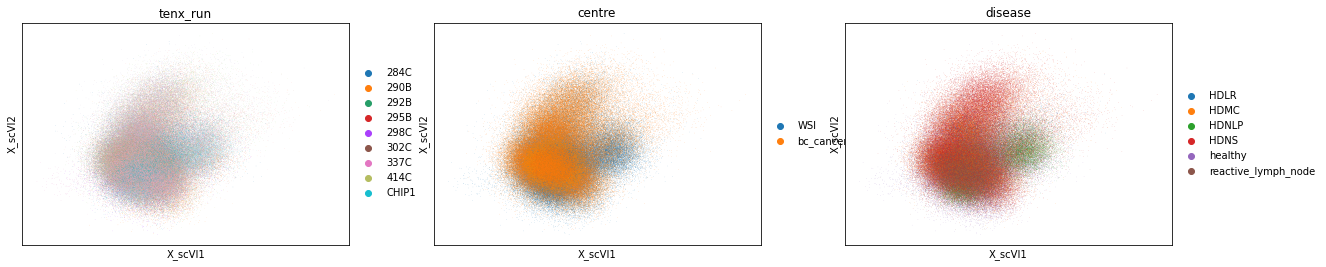

In [26]:
sc.pl.embedding(adata, basis = "X_scVI", color = ['tenx_run', 'centre', 'disease'], components = ['1,2'])

In [27]:
#save the objects
scvi_model.save("../data/trained_scvi_model/") #save the model

In [28]:
adata.write("../data/scvi_trained_adata.h5ad") #save the adata object 